# **Bài tập thực hành 2: Xây dựng cây quyết định và rừng cây trên dữ liệu bệnh tiểu đường**

Dữ liệu lấy từ: https://www.kaggle.com/code/tumpanjawat/diabetes-eda-random-forest-hp

## **Nhiệm vụ 1: Xây dựng cây quyết định bằng thư viện Scikit-Learn**

### **1. Import các thư viện cần thiết**

In [15]:
# Import các thư viện cần thiết
import numpy as np  # tính toán số học
import pandas as pd  # xử lý dữ liệu
import matplotlib.pyplot as plt  # vẽ biểu đồ
%matplotlib inline
import matplotlib as mpl  # thêm chức năng vẽ
mpl.rcParams['figure.dpi'] = 400  # hình ảnh độ phân giải cao

### **2. Nạp dữ liệu và chuẩn bị features**

In [ ]:
# Nạp dữ liệu
df = pd.read_csv("data/diabetes_prediction_dataset.csv")

# Lấy danh sách các cột
features_response = df.columns.tolist()

# Loại bỏ các features không liên quan
items_to_remove = ['gender', 'smoking_history']  # loại bỏ các biến phân loại
features_response = [item for item in features_response if item not in items_to_remove]

print("Các features được sử dụng:", features_response)

Các features được sử dụng: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


### **3. Chuẩn bị dữ liệu cho tập train và test**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(
    df[features_response[:-1]].values,  # loại bỏ cột target (diabetes)
    df['diabetes'].values,  # cột target
    test_size=0.2,  # 20% dữ liệu cho test
    random_state=24  # đặt seed cho tính tái tạo
)

### **4. Xây dựng cây quyết định**

In [16]:
# Tạo và huấn luyện cây quyết định
# Khởi tạo cây quyết định với độ sâu tối đa là 2
dt = tree.DecisionTreeClassifier(max_depth=2, random_state=42)

print("Bắt đầu huấn luyện mô hình...")
# Huấn luyện mô hình
dt.fit(X_train, y_train)
print("Hoàn thành huấn luyện mô hình!")

# In điểm số trên tập test
score = dt.score(X_test, y_test)
print(f"\nĐộ chính xác trên tập test: {score:.4f}")

Bắt đầu huấn luyện mô hình...
Hoàn thành huấn luyện mô hình!

Độ chính xác trên tập test: 0.9742


### **5. Hiển thị cây quyết định**

<Figure size 8000x4000 with 0 Axes>

<Figure size 8000x4000 with 0 Axes>

<Figure size 8000x4000 with 0 Axes>

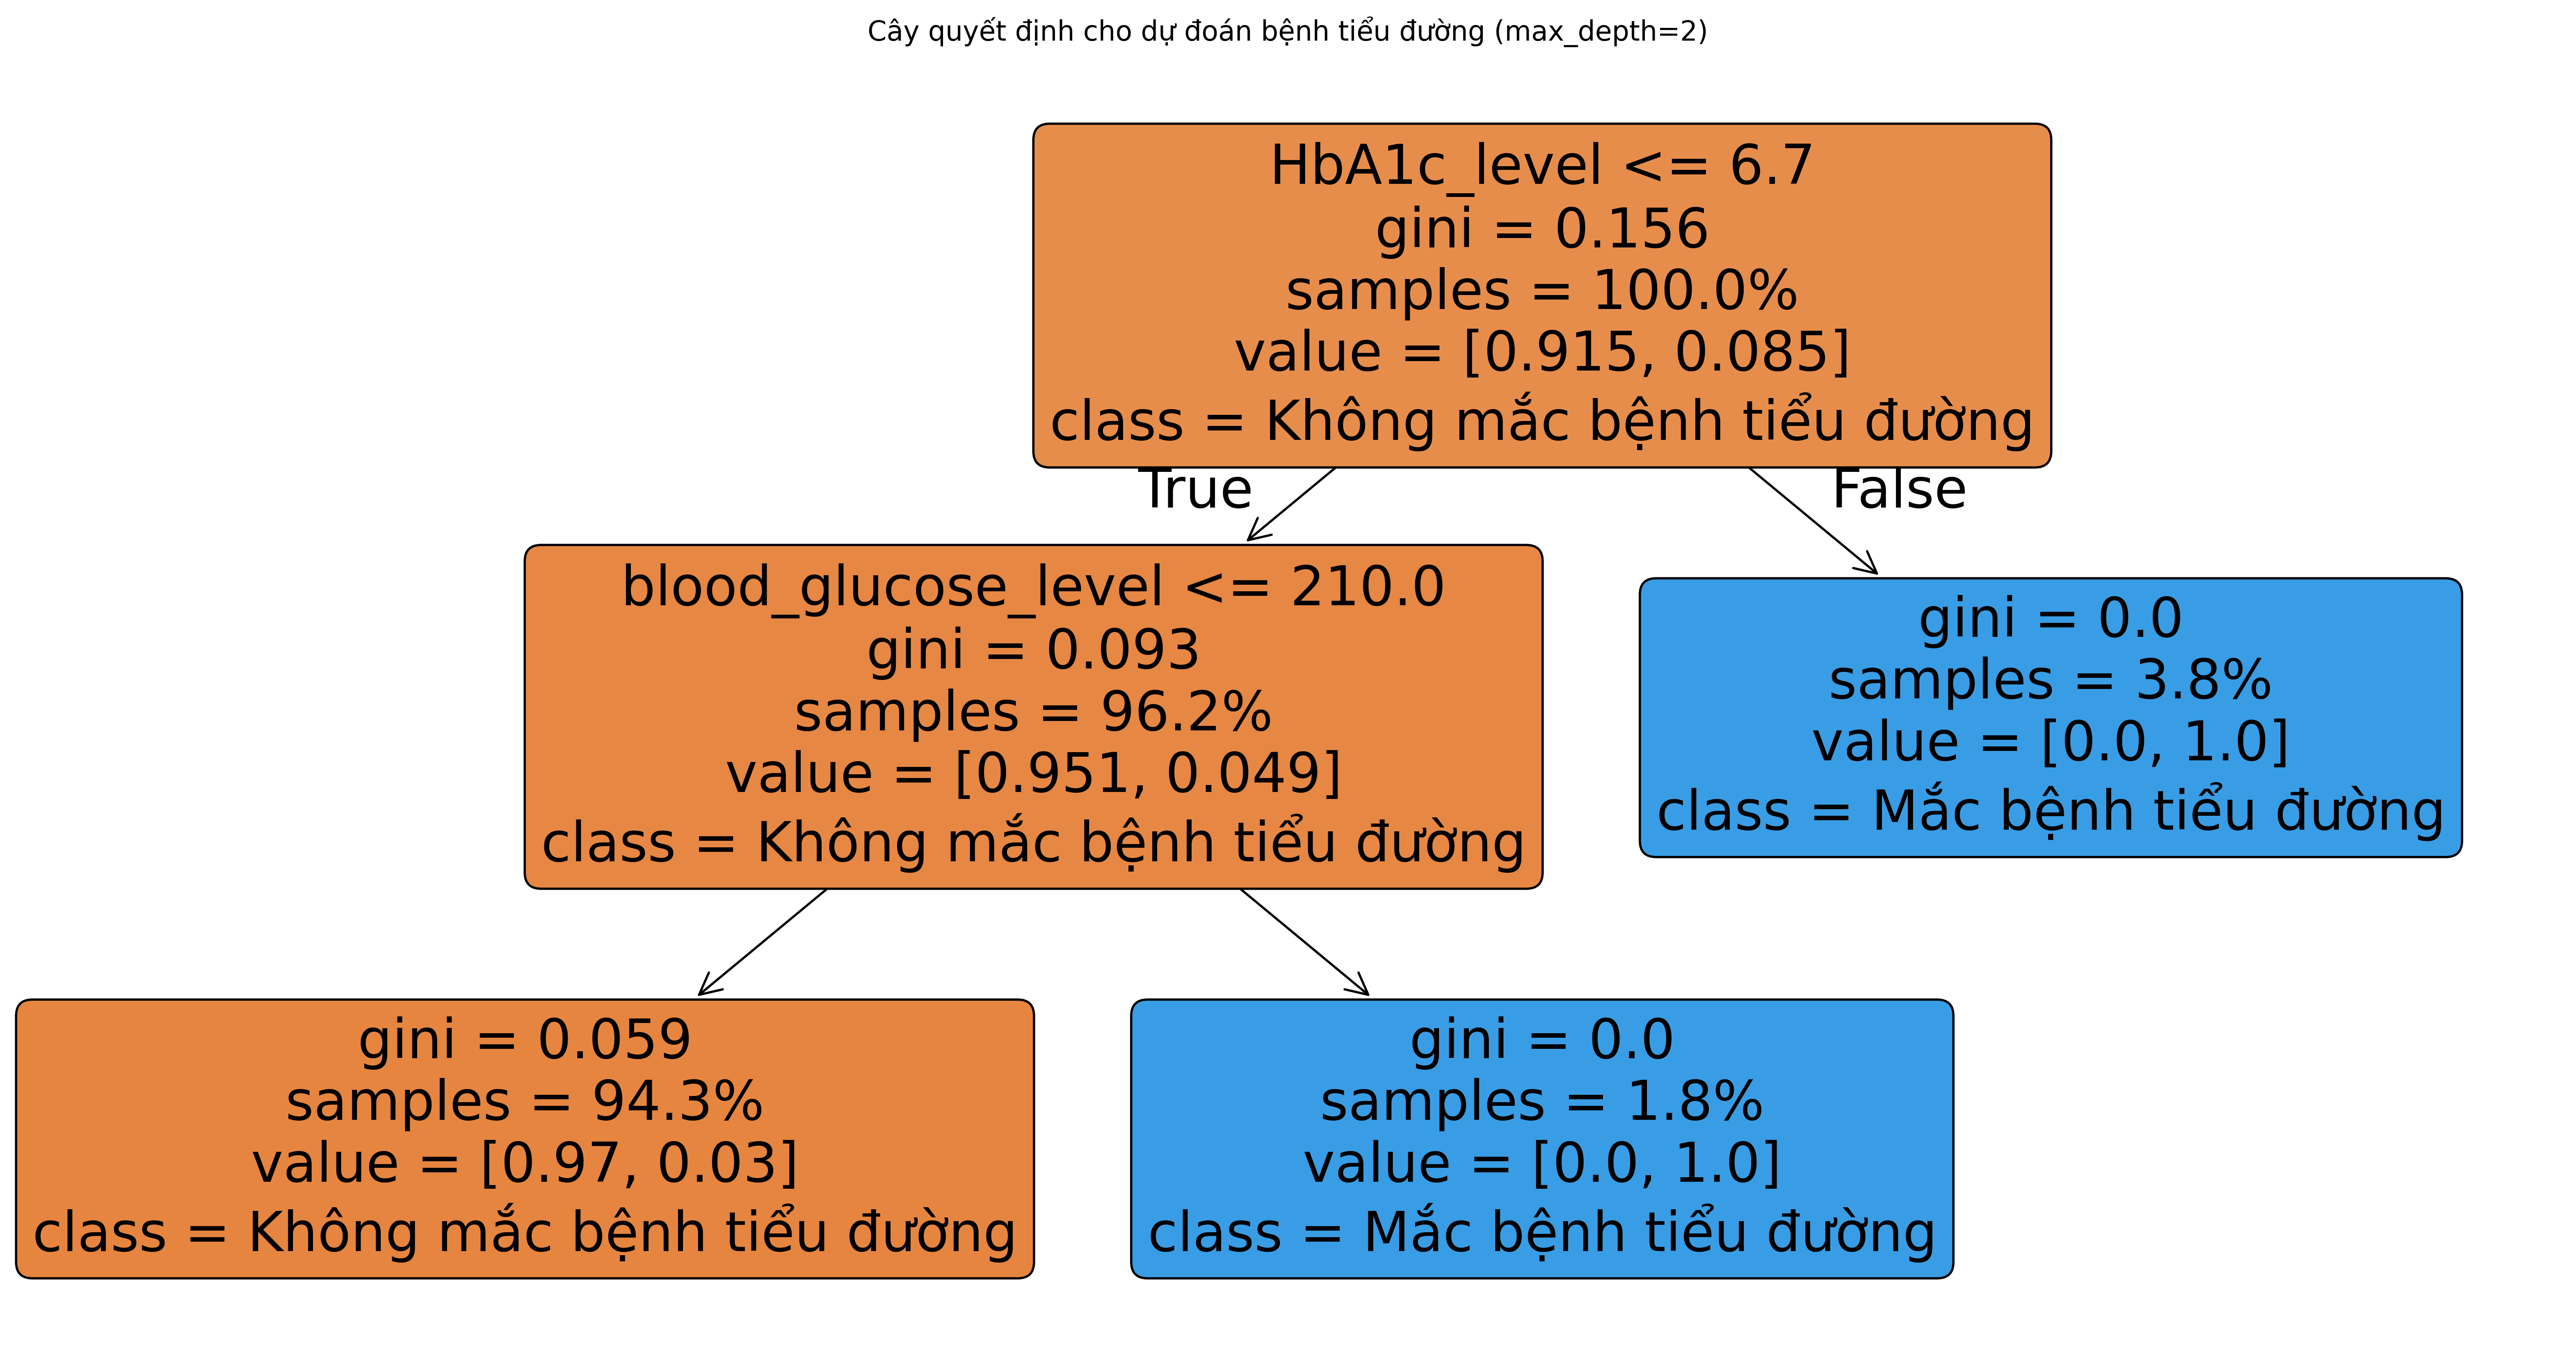

In [17]:
# Kiểm tra xem mô hình đã được huấn luyện chưa
if hasattr(dt, 'tree_'):
    # Thiết lập kích thước hình vẽ
    plt.figure(figsize=(20,10))
    
    # Vẽ cây quyết định bằng plot_tree
    tree.plot_tree(dt, 
                   feature_names=features_response[:-1],
                   class_names=['Không mắc bệnh tiểu đường', 'Mắc bệnh tiểu đường'],
                   filled=True,  # tô màu nodes
                   rounded=True,  # bo tròn góc
                   proportion=True)  # hiển thị tỷ lệ mẫu
    
    # Thêm tiêu đề
    plt.title('Cây quyết định cho dự đoán bệnh tiểu đường (max_depth=2)', pad=20)
    
    # Hiển thị biểu đồ
    plt.show()
else:
    print("Lỗi: Mô hình chưa được huấn luyện. Vui lòng chạy cell huấn luyện mô hình trước.")

## **Nhiệm vụ 2: Tìm tham số tối ưu cho cây quyết định**

### **1. Tạo cây quyết định và thiết lập GridSearchCV**

In [18]:
from sklearn.model_selection import GridSearchCV

# Thiết lập các giá trị max_depth để thử nghiệm
params = {'max_depth': [1, 2, 4, 6, 8, 10, 12]}

# Tạo cây quyết định mới
dt = tree.DecisionTreeClassifier()

# Thiết lập GridSearchCV
cv = GridSearchCV(dt, param_grid=params, 
                 scoring='roc_auc',  # đánh giá bằng ROC AUC
                 n_jobs=None, 
                 refit=True, 
                 cv=4,  # 4-fold cross-validation
                 verbose=1,
                 error_score=np.nan,
                 return_train_score=True)  # để đánh giá bias và variance

# Huấn luyện và tìm tham số tối ưu
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


,estimator,DecisionTreeClassifier()
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'gini'


### **2. Vẽ biểu đồ đánh giá mô hình với các độ sâu khác nhau**

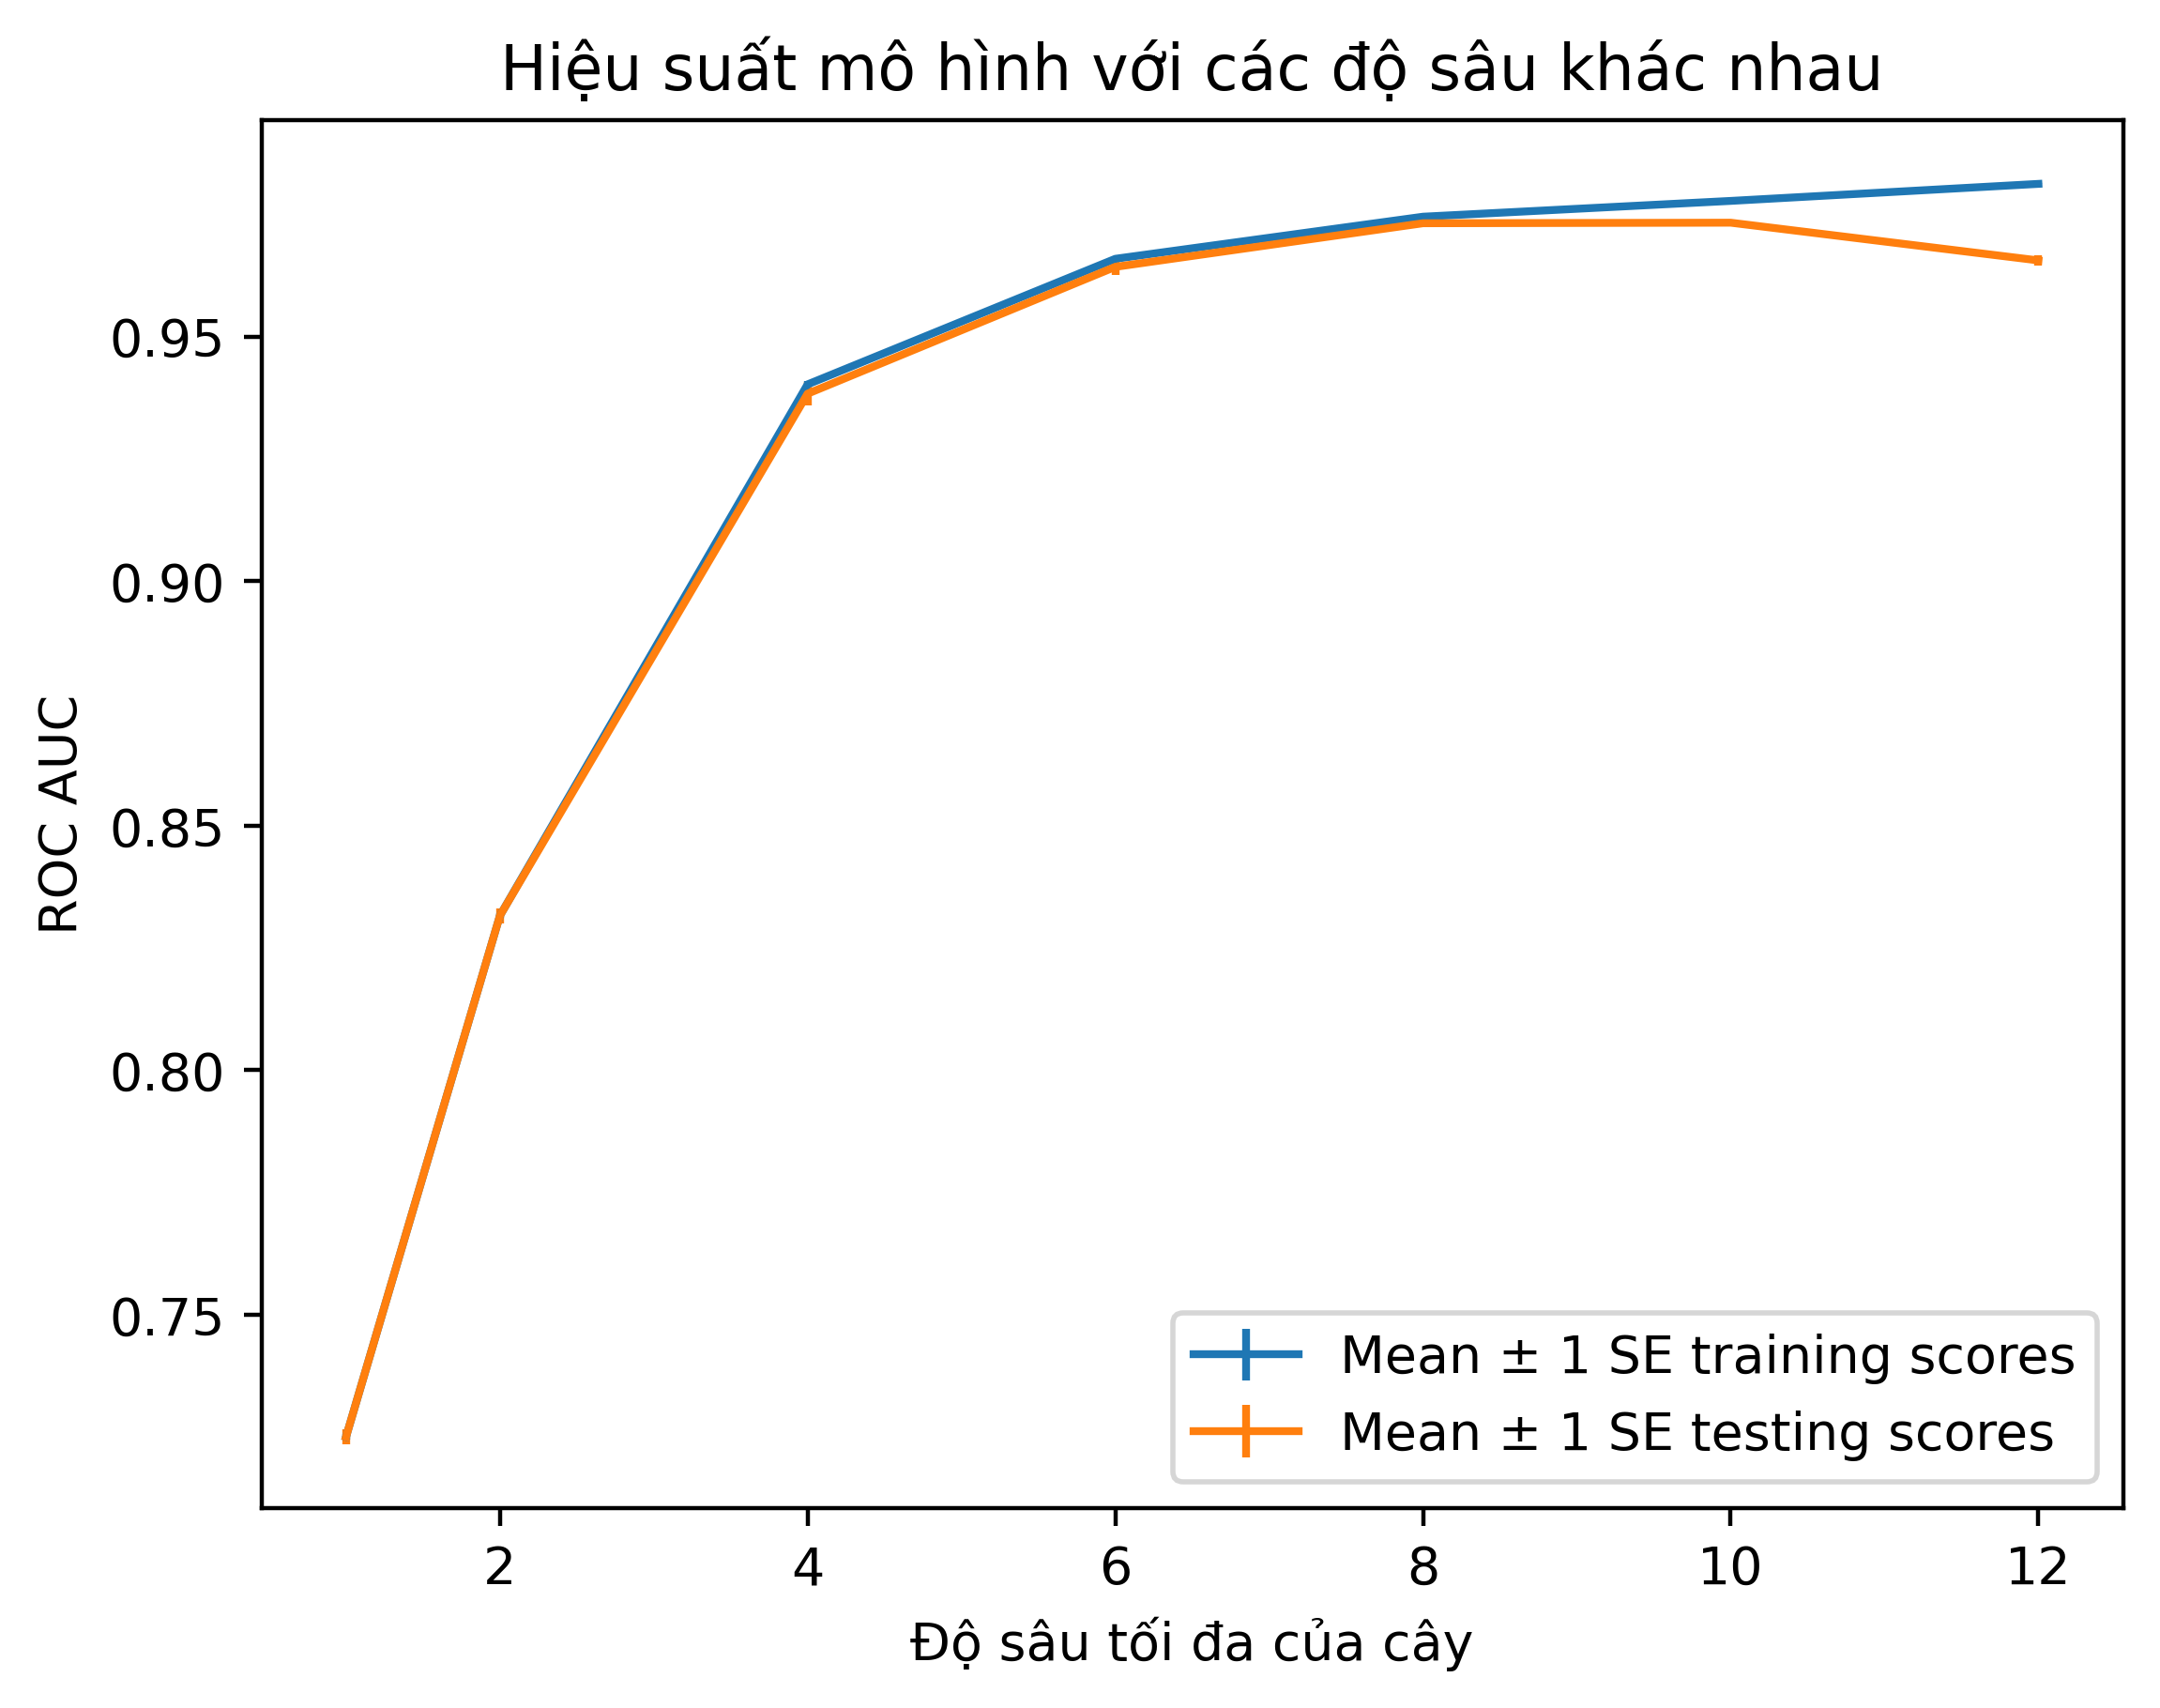

In [19]:
# Chuyển kết quả GridSearch thành DataFrame
cv_results_df = pd.DataFrame(cv.cv_results_)

# Tạo biểu đồ
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
           cv_results_df['mean_train_score'],
           yerr=cv_results_df['std_train_score']/np.sqrt(4),
           label='Mean ± 1 SE training scores')
ax.errorbar(cv_results_df['param_max_depth'],
           cv_results_df['mean_test_score'],
           yerr=cv_results_df['std_test_score']/np.sqrt(4),
           label='Mean ± 1 SE testing scores')

# Thêm nhãn và tiêu đề
ax.legend()
plt.xlabel('Độ sâu tối đa của cây')
plt.ylabel('ROC AUC')
plt.title('Hiệu suất mô hình với các độ sâu khác nhau')
plt.show()

## **Nhiệm vụ 3: Xây dựng rừng cây (Random Forest)**

### **1. Tạo mô hình Random Forest**

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Tạo mô hình Random Forest với các tham số cơ bản
rf = RandomForestClassifier(
    n_estimators=10,  # số lượng cây
    criterion='gini',  # tiêu chí phân chia
    max_depth=3,  # độ sâu tối đa của mỗi cây
    min_samples_split=2,  # số mẫu tối thiểu để phân chia node
    min_samples_leaf=1,  # số mẫu tối thiểu ở node lá
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',  # số features tối đa cho mỗi phân chia
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,  # có lấy mẫu bootstrap hay không
    oob_score=False,
    n_jobs=None,
    random_state=4,
    verbose=0,
    warm_start=False,
    class_weight=None
)

### **2. Tìm tham số tối ưu và huấn luyện mô hình**

In [21]:
# Thiết lập grid search cho số lượng cây
rf_params_ex = {'n_estimators': list(range(10, 110, 10))}

# Thực hiện grid search
cv_rf_ex = GridSearchCV(rf, param_grid=rf_params_ex,
                       scoring='roc_auc',
                       n_jobs=None,
                       refit=True,
                       cv=4,
                       verbose=1,
                       error_score=np.nan,
                       return_train_score=True)

# Huấn luyện mô hình
cv_rf_ex.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


,estimator,RandomForestC...andom_state=4)
,param_grid,"{'n_estimators': [10, 20, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,90


### **3. Vẽ biểu đồ đánh giá mô hình**

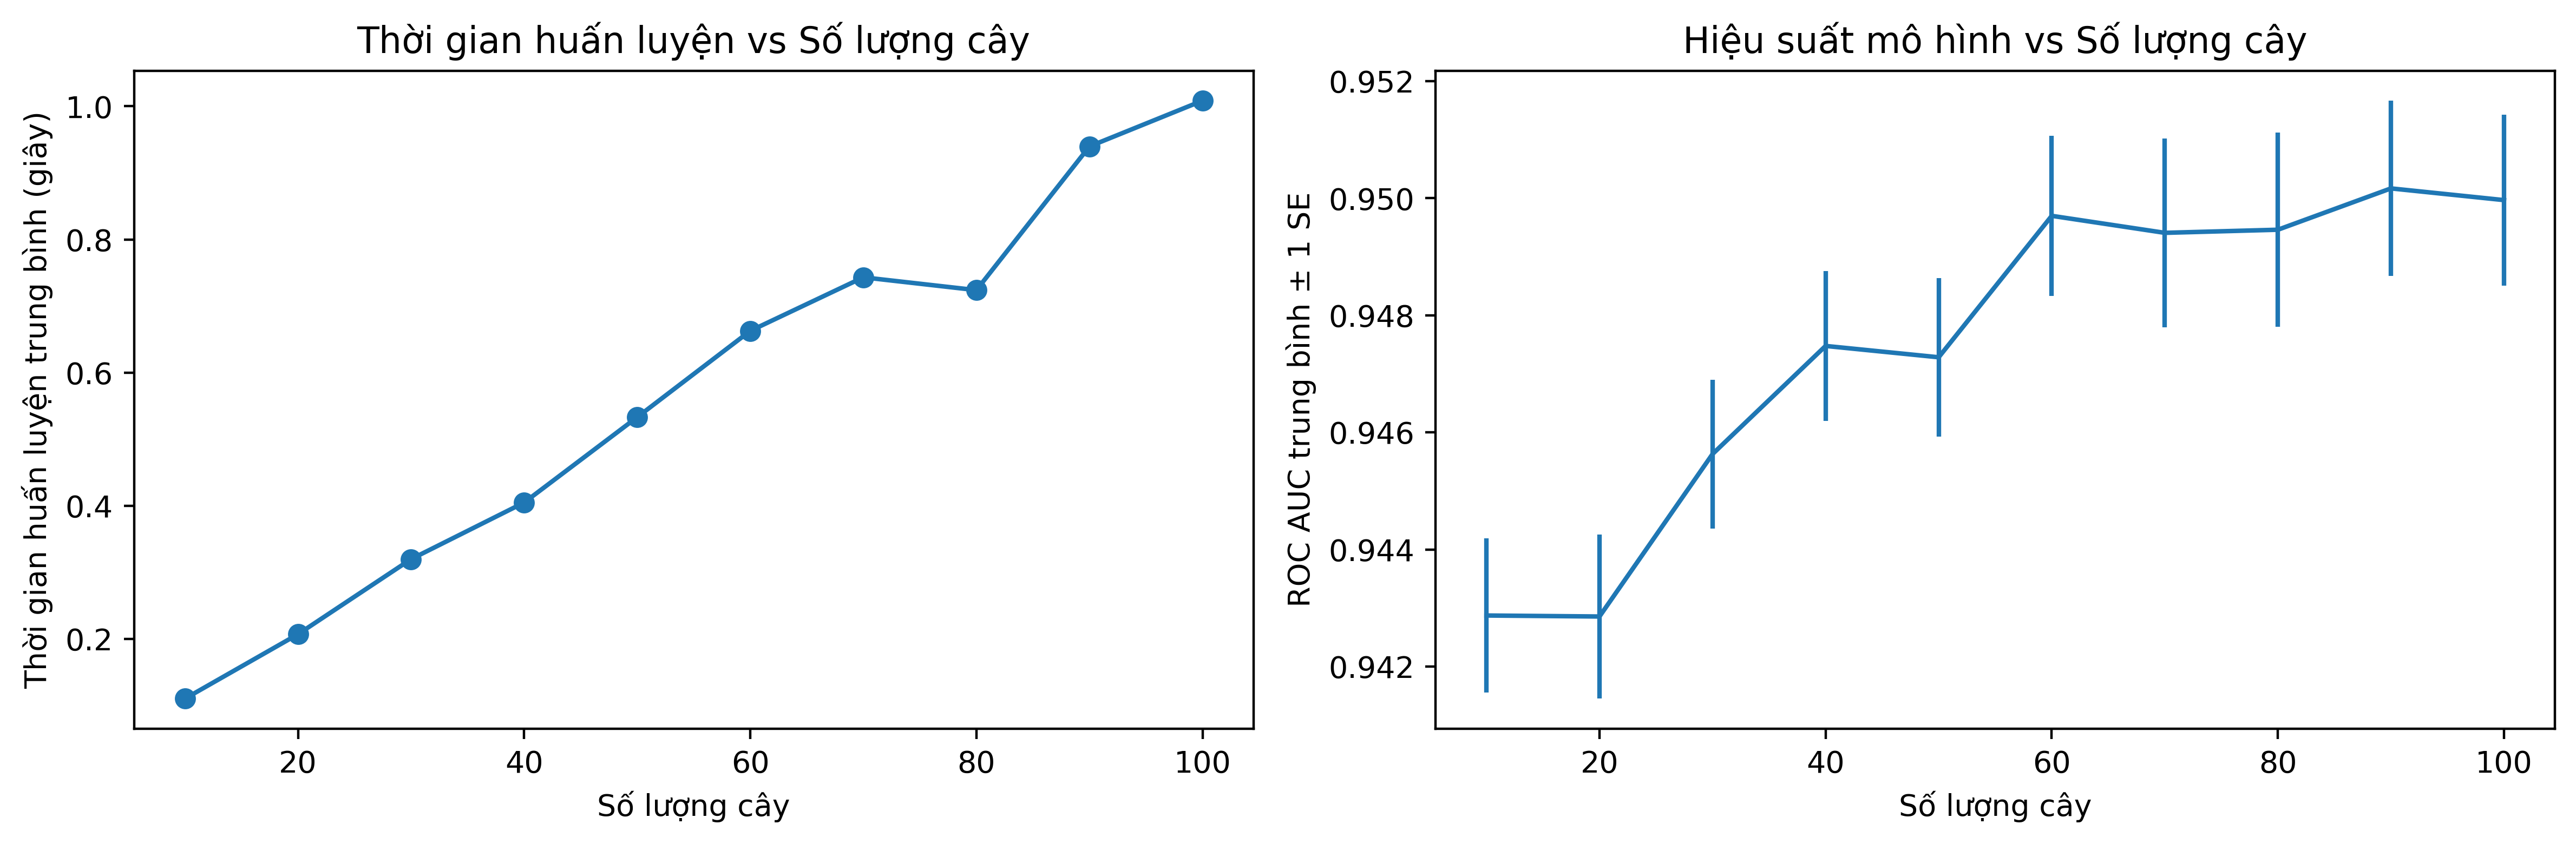

In [22]:
# Chuyển kết quả sang DataFrame
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)

# Tạo biểu đồ
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Biểu đồ thời gian huấn luyện
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],
            cv_rf_ex_results_df['mean_fit_time'],
            '-o')
axs[0].set_xlabel('Số lượng cây')
axs[0].set_ylabel('Thời gian huấn luyện trung bình (giây)')
axs[0].set_title('Thời gian huấn luyện vs Số lượng cây')

# Biểu đồ điểm ROC AUC
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'],
                cv_rf_ex_results_df['mean_test_score'],
                yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4))
axs[1].set_xlabel('Số lượng cây')
axs[1].set_ylabel('ROC AUC trung bình ± 1 SE')
axs[1].set_title('Hiệu suất mô hình vs Số lượng cây')

plt.tight_layout()
plt.show()

### **4. Xem tham số tối ưu và độ quan trọng của các features**

Tham số tối ưu: {'n_estimators': 90}


<Figure size 4000x2400 with 0 Axes>

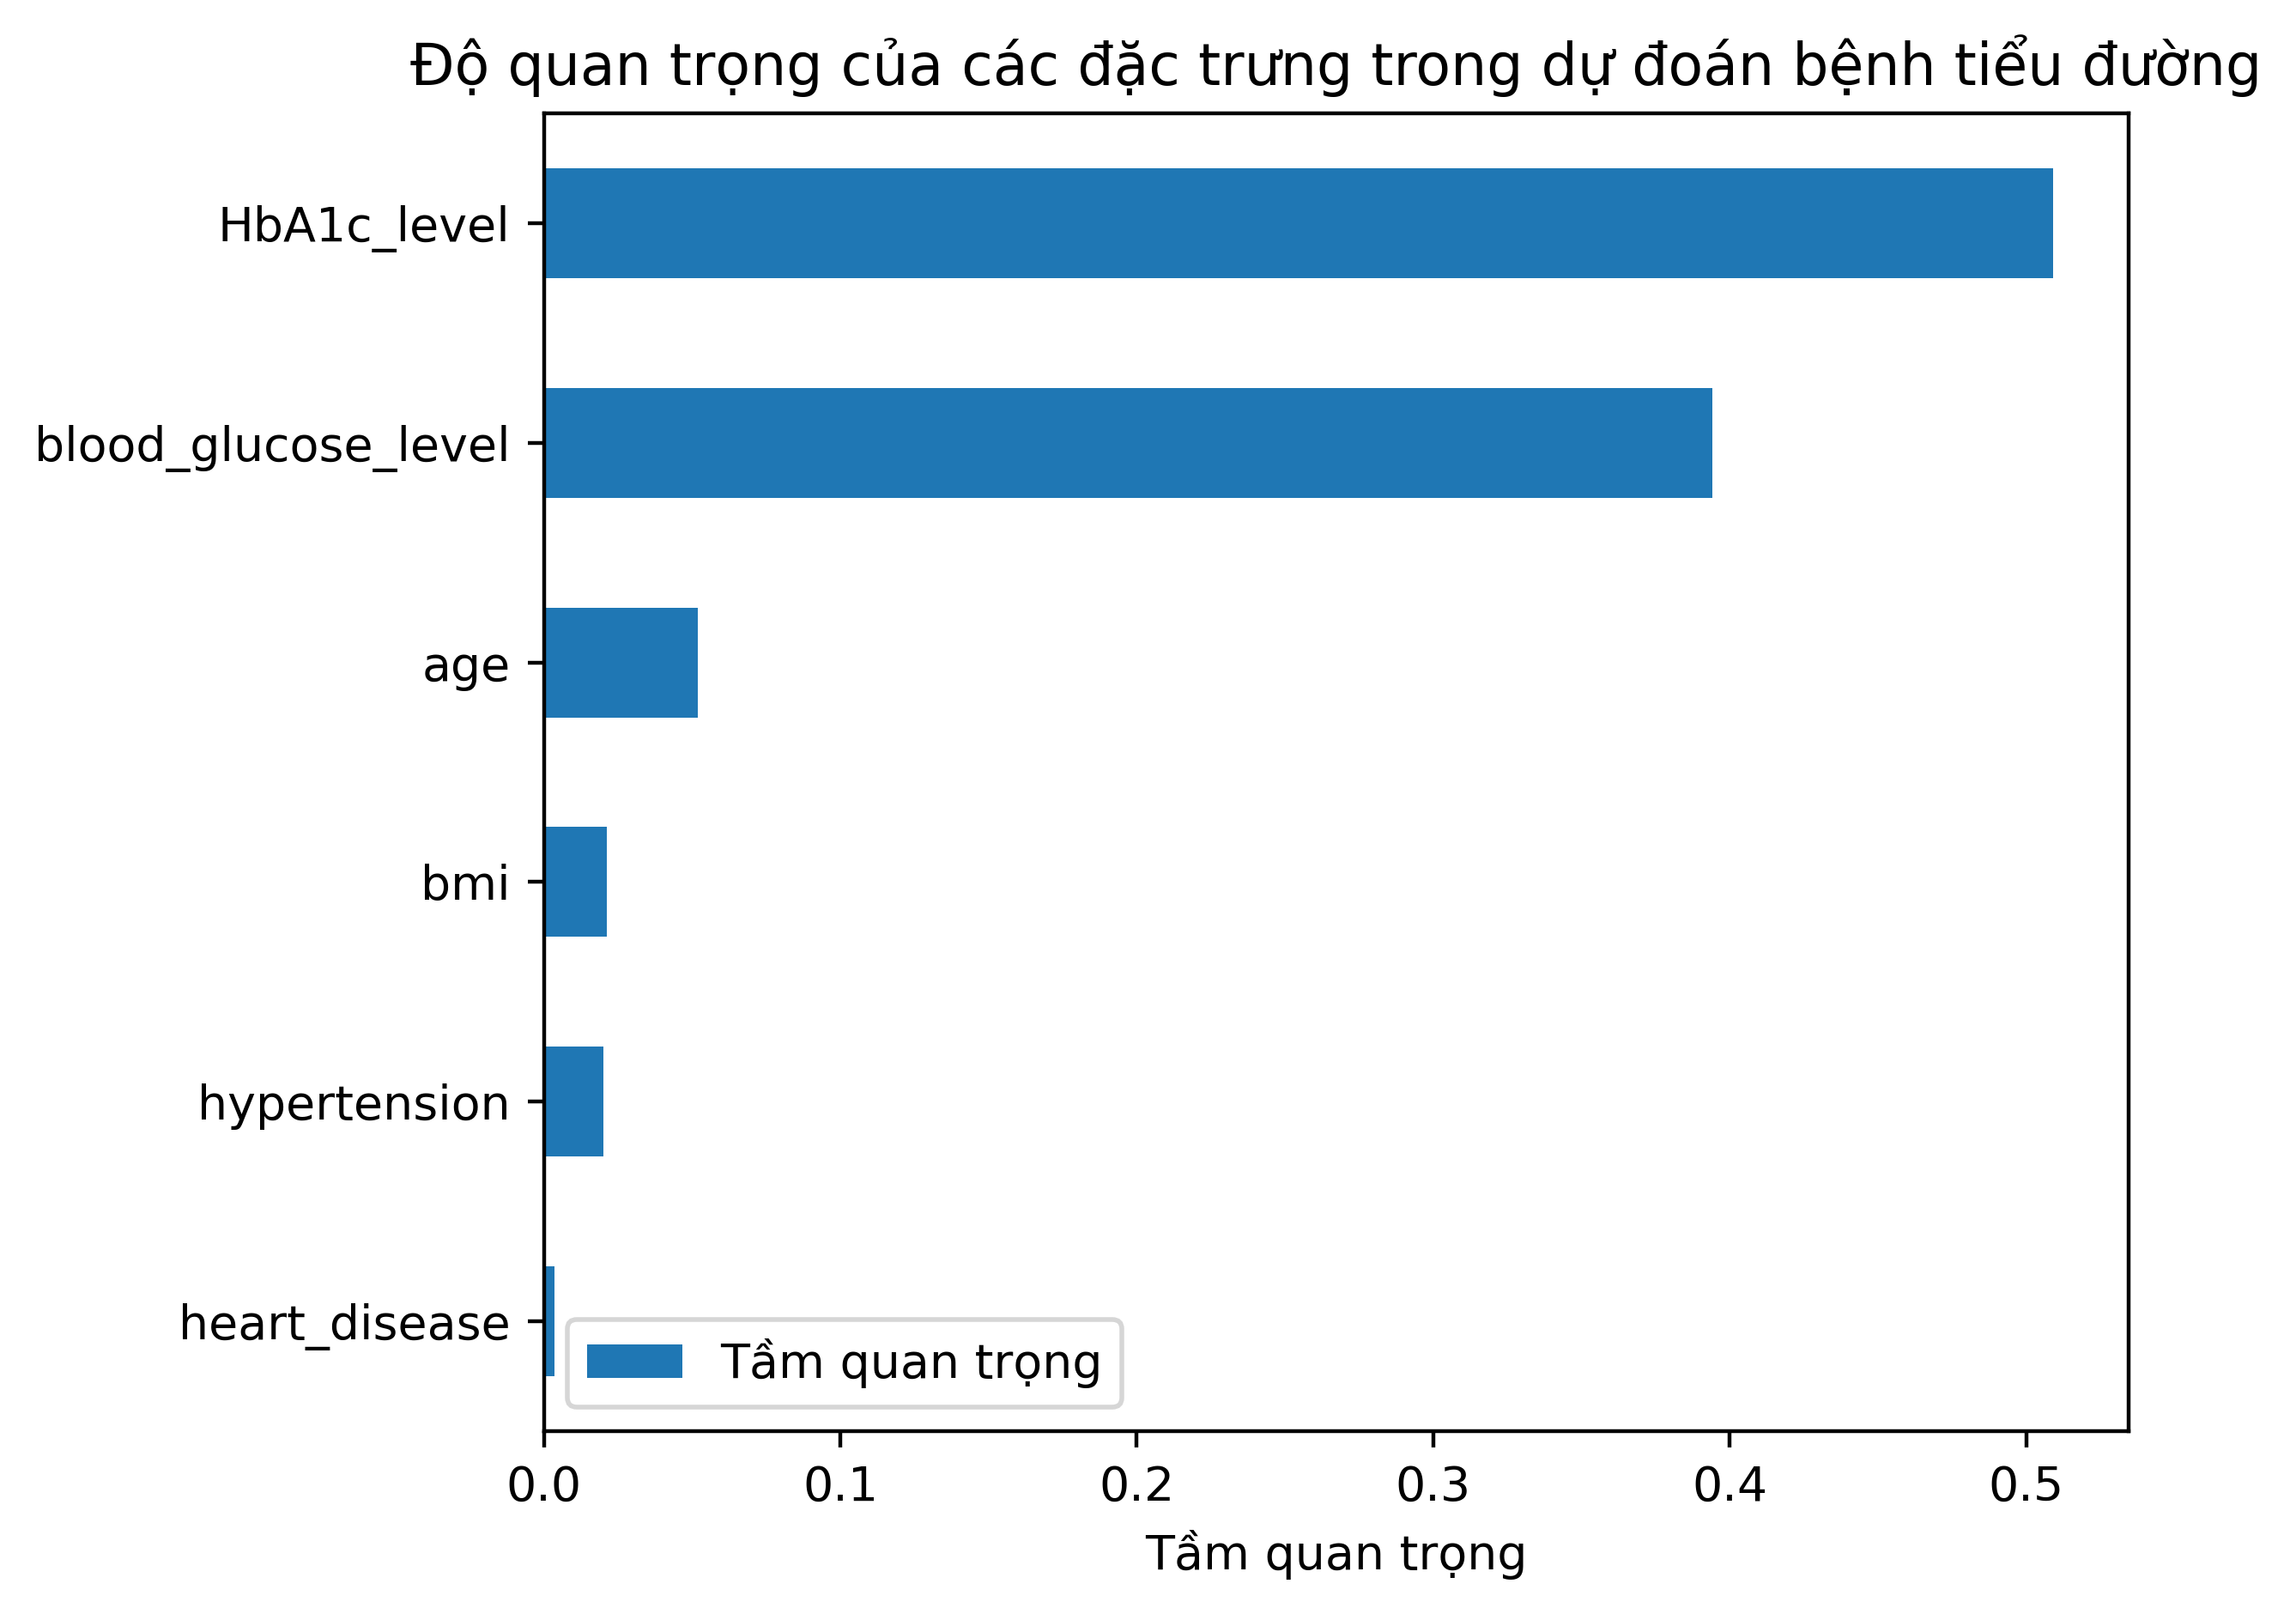

In [23]:
# Xem tham số tối ưu
print("Tham số tối ưu:", cv_rf_ex.best_params_)

# Tạo DataFrame chứa độ quan trọng của các features
feat_imp_df = pd.DataFrame({
    'Tầm quan trọng': cv_rf_ex.best_estimator_.feature_importances_
}, index=features_response[:-1])

# Vẽ biểu đồ độ quan trọng của các features
plt.figure(figsize=(10, 6))
feat_imp_df.sort_values('Tầm quan trọng', ascending=True).plot.barh()
plt.title('Độ quan trọng của các đặc trưng trong dự đoán bệnh tiểu đường')
plt.xlabel('Tầm quan trọng')
plt.tight_layout()
plt.show()